# Transfer Learning

## Import Packages

In [1]:
# !pip uninstall ml_project_util -y
!pip install git+https://github.com/aris-gk3/ml_project_util.git

  Cloning https://github.com/aris-gk3/ml_project_util.git to /tmp/pip-req-build-ok93vzd0
  Running command git clone --filter=blob:none --quiet https://github.com/aris-gk3/ml_project_util.git /tmp/pip-req-build-ok93vzd0
  Resolved https://github.com/aris-gk3/ml_project_util.git to commit 62c6be5dba2d44b545daa677b6e6d9dcd247920b
  Preparing metadata (setup.py) ... done
  Created wheel for ml_project_util: filename=ml_project_util-0.1-py3-none-any.whl size=23354 sha256=b63cc2d4dbd180308df0c7c51af33858cfa3ac88504dcd2718f694a03eb90b84
  Stored in directory: /tmp/pip-ephem-wheel-cache-8dzewpz4/wheels/9b/33/7a/e8e8f55a4c6aa39df26369c48b9e3497c6dde4c7663912f8ef
Successfully built ml_project_util


In [2]:
import tensorflow as tf
import os
from tensorflow.keras import layers, models # type: ignore
from tensorflow.keras.applications import VGG16 # type: ignore
# Local Packages
from ml_project_util.path import path_definition
from ml_project_util.train import train, freeze_layers, unfreeze_head, unfreeze_block
from ml_project_util.quantization_util import quant_model, quant_bw_search
from ml_project_util.model_evaluation import model_evaluation_precise

2025-09-23 11:11:19.997599: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758625880.176325      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758625880.230584      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Define Variable Paths

In [3]:
dict = path_definition(ds_rel_path='oxford-flowers-17-restructured')
BASE_PATH = dict['BASE_PATH']
PATH_DATASET = dict['PATH_DATASET']
PATH_TEST = dict['PATH_TEST']
PATH_RAWDATA = dict['PATH_RAWDATA']
PATH_JOINEDDATA = dict['PATH_JOINEDDATA']
PATH_SAVEDMODELS = dict['PATH_SAVEDMODELS']

ds_rel_path set to: oxford-flowers-17-restructured


## Load Model for PTQ & Evaluation

In [4]:
model_name = 'OF2_P1_008_val0.3397_025_val0.1014'
model_path = "/kaggle/input/of2_p1_008_val0.3397_025_val0.1014/keras/default/1/OF2_P1_008_val0.3397_025_val0.1014.keras"
model = tf.keras.models.load_model(model_path)

I0000 00:00:1758625895.466653      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [5]:
from ml_project_util.quantization_util import complete_dict_search


In [6]:
complete_dict_search(model, model_name, mode='sv', force=1, debug=1, num_bits=8);

Calculating the Input Range...
Input tensor range over 300 images:
min = -123.68000030517578, max = 151.06100463867188
Saved json in: /kaggle/working/Docs_Reports/Quant/Ranges/input_range.json


I0000 00:00:1758625902.558345      19 cuda_dnn.cc:529] Loaded cuDNN version 90300


input_layer: min = -151.0610, max = 151.0610
block1_conv1: min = 0.0000, max = 1029.2603
block1_conv2: min = 0.0000, max = 4360.5776
block2_conv1: min = 0.0000, max = 8838.3828
block2_conv2: min = 0.0000, max = 12915.8730
block3_conv1: min = 0.0000, max = 15248.2734
block3_conv2: min = 0.0000, max = 17254.2285
block3_conv3: min = 0.0000, max = 18250.2715
block4_conv1: min = 0.0000, max = 13415.9688
block4_conv2: min = 0.0000, max = 7997.4980
block4_conv3: min = 0.0000, max = 4699.6680
block5_conv1: min = 0.0000, max = 3049.4363
block5_conv2: min = 0.0000, max = 1789.3046
block5_conv3: min = 0.0000, max = 752.4697
dense: min = 0.0000, max = 57.0123
dense_1: min = 0.0000, max = 1.0000
Saved activation ranges in /kaggle/working/Docs_Reports/Quant/Ranges/OF2_P1_008_val0.3397_025_activation_range.json
{
  "block1_conv1": {
    "weight": {
      "min": -0.6714000701904297,
      "max": 0.6085159182548523
    },
    "bias": {
      "min": -0.015828926116228104,
      "max": 2.0640370845794678

## Try PTQ & Evaluation (Evluate Correctness)

In [7]:
# model_evaluation_precise(model, mode='val')
model_evaluation_precise(model, mode='test')

Found 340 files belonging to 17 classes.
Start evaluating batches


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Batch Number: 10
Precise test accuracy: 0.95294
Precise test loss: 0.28112


(0.9529412, 0.2811193805407075)

Quantizing model to 7 bits...
Read activation range json from /kaggle/working/Docs_Reports/Quant/Ranges/OF2_P1_008_val0.3397_025_activation_range.json
Read weight range json from /kaggle/working/Docs_Reports/Quant/Ranges/OF2_P1_008_val0.3397_025_wt_range.json
Quantization on arbitrary symmetric ranges is applied.
Read sw activation quantization range from /kaggle/working/Docs_Reports/Quant/Ranges/OF2_P1_008_val0.3397_025_activation_range.json.
New model input shape: (None, 224, 224, 3)
Found 340 files belonging to 17 classes.
Start evaluating batches
Batch Number: 10
Precise test accuracy: 0.19412
Precise test loss: 2.48868
Read weight range json from /kaggle/working/Docs_Reports/Quant/Ranges/OF2_P1_008_val0.3397_025_wt_range.json
Read activation range json from /kaggle/working/Docs_Reports/Quant/Ranges/OF2_P1_008_val0.3397_025_activation_range.json
'7b' is missing or empty from dictionary.
['input_layer', 'block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 

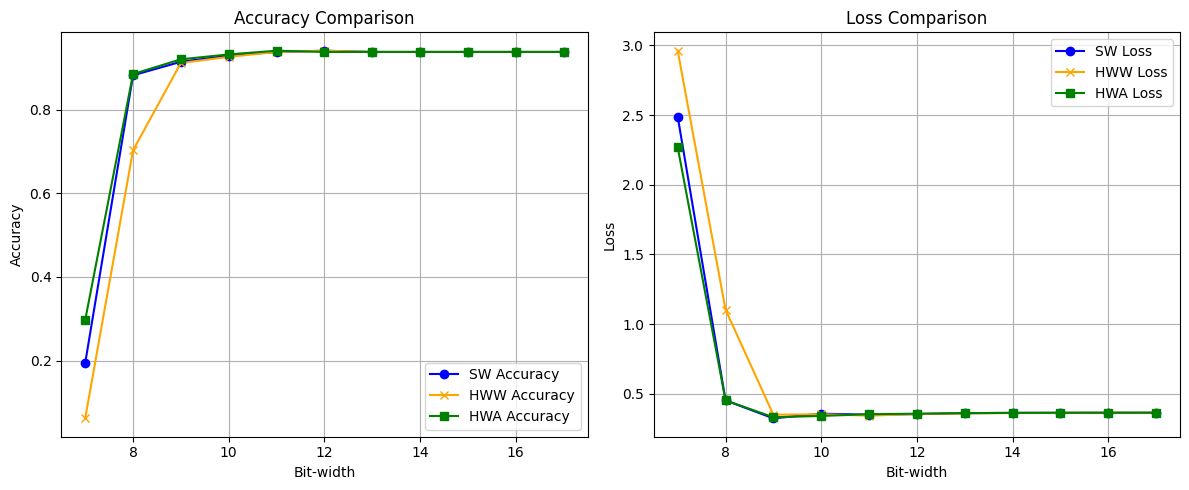

{
    "7b": {
        "accuracy": 0.19411765038967133,
        "loss": 2.4886764947105857
    },
    "8b": {
        "accuracy": 0.8823529481887817,
        "loss": 0.45196620506398816
    },
    "9b": {
        "accuracy": 0.9147058725357056,
        "loss": 0.3232081560527577
    },
    "10b": {
        "accuracy": 0.929411768913269,
        "loss": 0.3567375638905694
    },
    "11b": {
        "accuracy": 0.9382352828979492,
        "loss": 0.34921999117907354
    },
    "12b": {
        "accuracy": 0.9411764740943909,
        "loss": 0.35332657239016363
    },
    "13b": {
        "accuracy": 0.9382352828979492,
        "loss": 0.3603435467271244
    },
    "14b": {
        "accuracy": 0.9382352828979492,
        "loss": 0.36255021866630105
    },
    "15b": {
        "accuracy": 0.9382352828979492,
        "loss": 0.3629711620947894
    },
    "16b": {
        "accuracy": 0.9382352828979492,
        "loss": 0.3634037445573246
    },
    "17b": {
        "accuracy": 0.938235282897

In [8]:
%%time
quant_bw_search(model, model_name, range(7,18))

---